# Computing statistics from trajectories

In [1]:
#!/usr/bin/env python
# coding: utf-8

import contracts
contracts.disable_all()

import geometry as geo
import math
import numpy as np
from os import path, listdir
from scipy import stats
import yaml

import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_svg, ipython_draw_html
from duckietown_world.world_duckietown.tile import get_lane_poses
from duckietown_world import draw_static



INFO:dt-world:duckietown-world 5.1.2
INFO:zuper-typing:zuper-typing 5.3.0
INFO:zuper-commons:zuper-commons 5.0.11


## Goal of the notebook

Familiarize yourself with duckietown world, with an example. The goal is to plot the average trajectory along with its standard deviation for a set of experiments done on fixed map and starting conditions. 

Let's start with visualizing the map.

INFO:dt-world:loading map linus_loop
INFO:dt-world:area: RectangularArea(pmin=[ 0.    -0.156],pmax=[1.72371067 1.33500001])
INFO:dt-world:Written SVG to out/ipython_draw_svg/139839505138192/drawing.svg
INFO:dt-world:Written HTML to out/ipython_draw_svg/139839505138192/drawing.html


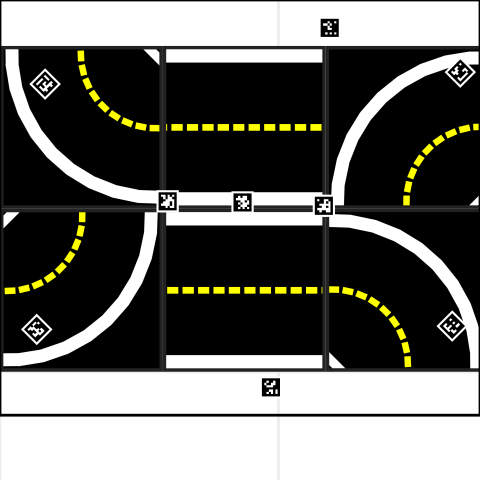

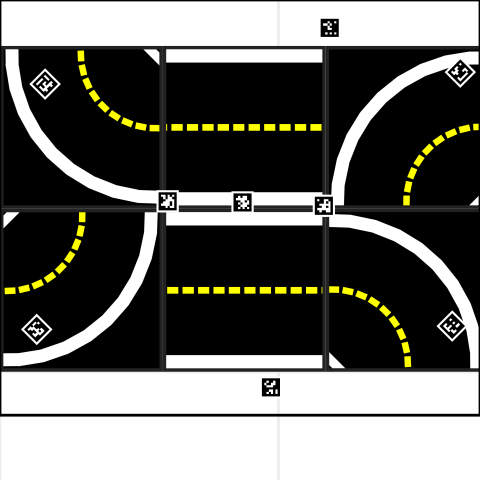

In [2]:
m = dw.load_map('linus_loop')

ipython_draw_svg(m)

## Some utilities that we are going to use later

In [3]:

class AFakeBar(dw.PlacedObject):
    "Ellipse object with a large ration between the radii"

    def __init__(self, len=0, fill_opacity=0.5, color='pink', *args, **kwargs):
        self.len = len
        self.fill_opacity = fill_opacity
        self.color = color
        dw.PlacedObject.__init__(self, *args, **kwargs)

    def draw_svg(self, drawing, g):
        # drawing is done using the library svgwrite
        c = drawing.ellipse(center=(0, 0), r=(0.03,self.len), fill=self.color, fill_opacity=self.fill_opacity)
        g.add(c)
        # draws x,y axes
        dw.draw_axes(drawing, g)
        

class Circle(dw.PlacedObject):
    "Circle object."

    def __init__(self, radius, color='pink', *args, **kwargs):
        self.radius = radius
        self.color = color
        dw.PlacedObject.__init__(self, *args, **kwargs)

    def draw_svg(self, drawing, g):
        # drawing is done using the library svgwrite
        c = drawing.circle(center=(0, 0), r=self.radius, fill=self.color)
        g.add(c)
        # draws x,y axes
        dw.draw_axes(drawing, g)

    def extent_points(self):
        # set of points describing the boundary
        L = self.radius
        return [(-L, -L), (+L, +L)]


def relative_pose(q0, q1):
    "Computes the relative pose between two points in SE2"
    return geo.SE2.multiply(geo.SE2.inverse(q0), q1)


def interpolate(q0, q1, alpha):
    "Interpolates between two points in SE2, given a coefficient alpha."
    q1_from_q0 = relative_pose(q0, q1)
    vel = geo.SE2.algebra_from_group(q1_from_q0)
    rel = geo.SE2.group_from_algebra(vel * alpha)
    q = geo.SE2.multiply(q0, rel)
    return q


def extract_trajectory(localization_log):
    "From a log file from the localization system, extract a list of transforms describing the trajectory."

    final_trajectory = []

    len_trajectory = len(localization_log['trajectory_data'])
    x, y = np.zeros(len_trajectory), np.zeros(len_trajectory)
    R = np.zeros((3, 3, len_trajectory))
    phi = np.zeros((3, len_trajectory))

    for i, (time, traj) in enumerate(localization_log['trajectory_data'].items()):
        x[i] = np.array(traj[0])
        y[i] = np.array(traj[1])

        R[:, :, i] = np.reshape(np.array(traj[3:]), (3, 3))
        phi[:, i] = np.array([np.arctan2(-R[1, 2, i], R[2, 2, i]),
                              np.arctan2(R[0, 2, i], np.sqrt(R[0, 0, i] ** 2 + R[0, 1, i] ** 2)),
                              np.arctan2(-R[0, 1, i], R[0, 0, i])])

        z = phi[2, i]
        points = np.array([x[i], y[i]])
        final_trajectory.append([points, z])
    final_array = final_trajectory.copy()

    traj_tfs = []
    for entry in range(0, len(final_array)):
        x, y = final_array[entry][0][0:2]
        theta = final_array[entry][1]
        q = geo.SE2_from_translation_angle([x, y], theta)
        traj_tfs.append(q)

    return traj_tfs


def get_interpolated_points(center_line, trajectories):
    """Generates an interpolated point for each point on the center line, for each trajectory as long as the point
    lies between two trajectory points."""
    closest_behind = [None] * len(trajectories)
    interpolated_trajectories = []
    for center_point in center_line:
        interpolated_points = []
        for idx_t, traj in enumerate(trajectories):
            interpolated_point_traj = None
            begin_t = closest_behind[idx_t] if closest_behind[idx_t] else 0
            for idx_point in range(begin_t, len(traj)):
                if a_behind_b(a=traj[idx_point], b=center_point):
                    closest_behind[idx_t] = idx_point
                    continue

                if closest_behind[idx_t] is None:
                    # If there is no point behind we cannot compute the interpolation
                    interpolated_point_traj = None
                    break
                else:
                    try:
                        interpolated_point_traj = interpolate_magic(center_point,
                                                                    traj[closest_behind[idx_t]],
                                                                    traj[closest_behind[idx_t] + 1])
                        break

                    except IndexError:
                        print('The index is outside the list!')
                        interpolated_point_traj = None
                        break
            interpolated_points.append(interpolated_point_traj)
        interpolated_trajectories.append(interpolated_points)
    return interpolated_trajectories


def a_behind_b(a=None, b=None):
    """Check if a is behind b wrt the heading direction of a."""
    if a is None or b is None:
        return False
    rel_pose = relative_pose(b, a)
    return dw.SE2Transform.from_SE2(rel_pose).p[0] < 0


def interpolate_magic(center_pt, previous_pt, next_pt):
    """Returns an interpolated point between previoust_pt and next_pt at the height of center_pt"""
    tf_prev = relative_pose(center_pt, previous_pt)
    d_prev = dw.SE2Transform.from_SE2(tf_prev).p[0]

    tf_next = relative_pose(center_pt, next_pt)
    d_next = dw.SE2Transform.from_SE2(tf_next).p[0]

    alpha = np.abs(d_prev) / (np.abs(d_prev) + d_next)
    interpolated_pt = interpolate(previous_pt, next_pt, alpha)
    return interpolated_pt


def get_used_lanes(trajectories):
    """Returns a list with all used lanes and a dictionary containing the transform to each lane segment."""
    used_lane_segs = set()
    used_lane_segs_list = []
    lane_segs_tfs = dict()

    for traj in trajectories:
        for pose in traj:
            try:
                tl = list(get_lane_poses(m, pose))[0]
                lane_segment_name = tl.lane_segment_fqn

                if lane_segment_name not in used_lane_segs:
                    used_lane_segs.add(lane_segment_name)
                    used_lane_segs_list.append(lane_segment_name)
                    lane_segs_tfs[lane_segment_name] = tl.lane_segment_transform.asmatrix2d().m
            except IndexError:
                pass
    return used_lane_segs_list, lane_segs_tfs


def get_global_center_line(map, used_lane_segs, global_segs_SE2, pts_per_segment):
    "Builds a center line for all the used lanes in the global coordinate frame."
    center_line = []
    center_line_global = []
    center_line_global_tfs = []

    for i, lane_segment in enumerate(used_lane_segs):
        if lane_segment[2] == 'straight':
            n_inter = pts_per_segment['mid']
        elif lane_segment[-1] == 'lane2':
            n_inter = pts_per_segment['long']
        elif lane_segment[-1] == 'lane1':
            n_inter = pts_per_segment['short']
        lane = map[lane_segment]

        # The end point is part of next tile
        steps = np.linspace(0, len(lane.control_points) - 1, num=n_inter, endpoint=False)

        for beta in steps:
            center_point_local_SE2 = lane.center_point(beta)
            center_line.append(center_point_local_SE2)

            # get SE2 of the point in global coords
            center_point_global_SE2 = geo.SE2.multiply(global_segs_SE2[lane_segment],
                                                       center_point_local_SE2)

            center_line_global.append(center_point_global_SE2)
            center_line_global_tfs.append(dw.SE2Transform.from_SE2(center_point_global_SE2))
    return center_line_global, center_line_global_tfs

def get_trajectories_statistics(trajectories):
    """Computes mean trajectory and std deviations for y and angle given a list of trajectories sampled at the same x"""
    mean_tfs = []
    std_y = []
    std_heading = []

    start_idx = None
    end_idx = None
    # We need to find the first amd last index for which all trajectories have a point
    for idx, trajs_points in enumerate(trajectories):
        if all(trajs_points) and start_idx is None:
            start_idx = idx
        elif not all(trajs_points) and start_idx is not None:
            end_idx = idx
            break
    end_idx = -1 if end_idx is None else end_idx
    complete_trajectories = trajectories[start_idx:end_idx]
    for tfs in complete_trajectories:
        xs = [tf.p[0] for tf in tfs]
        ys = [tf.p[1] for tf in tfs]
        headings = [tf.theta for tf in tfs]
        mean_x = np.mean(xs)
        mean_y = np.mean(ys)
        # To compute mean angles we need to pay attention
        mean_angle = np.arctan2(np.mean(np.sin(headings)),np.mean(np.cos(headings)))
        
        mean_tfs.append(dw.SE2Transform.from_SE2(geo.SE2_from_translation_angle([mean_x, mean_y], mean_angle)))
        
        
        # Compute all transforms wrt to the mean trajectory to compute the standard deviations
        #lateral_deviation = [(mean_x-t.p[0])*np.sin(t.theta)+(mean_y-t.p[1])*np.cos(t.theta) for t in tfs]
        lateral_deviation = []
        mean_point = geo.SE2_from_translation_angle([mean_x, mean_y], mean_angle)
        for t in tfs:
            relative_tf = dw.SE2Transform.from_SE2(relative_pose(mean_point, t.as_SE2()))
            print(relative_tf)
            print(relative_tf.p[1])
            lateral_deviation.append(relative_tf.p[1])

        std_y.append(np.std(lateral_deviation))
        std_heading.append(stats.circstd(headings, low=-math.pi, high=math.pi))
        
    return mean_tfs, std_y, std_heading, start_idx, end_idx

## Loading data

First of all, we need to load some trajectories from the logs of the localization system. For this demo, we are going to use multiple evaluations on the same map, the logs are stored in the `logs` directory. If you have your own data, you can change the `experiment_dir` variable.

In [5]:
experiment_dir = ''

logs_path = path.join(experiment_dir, '../data/BenchmarkXY/yaml')

localization_logs = [path.join(logs_path, f) for f in listdir(logs_path) if path.isfile(path.join(logs_path, f))]
print(f'Logs found: {localization_logs}')

all_logs = []
for filename in localization_logs:
    with open(filename, 'r') as file:
        all_logs.append(yaml.safe_load(file))
        
# Load the evaluation map
m = dw.load_map('linus_loop')

# Get a list of all trajectories, each saved as list of transforms
all_trajectories = []
for log in all_logs:
    all_trajectories.append(extract_trajectory(log))

used_lane_segments_list, lane_segments_SE2 = get_used_lanes(all_trajectories)

Logs found: ['../data/BenchmarkXY/yaml/autobot01.yaml', '../data/BenchmarkXY/yaml/autobot18.yaml', '../data/BenchmarkXY/yaml/autobot02.yaml']


INFO:dt-world:loading map linus_loop


## Computing the average trajectory

Once we have our trajectories loaded, we can start to compute our average trajectory. To do so we first compute a center line that passes through each lane segment on which our Duckiebot passed. This will be used as a reference to re-sample the trajectories in order to have coherent data for comparison and averaging.

This part will take a lot of time if your map is very complex (i.e. `robotarium2`). This will improve once tile map and signal map get separated.

In [49]:
try:
    del m    
except:
    pass
m = dw.load_map('linus_loop')

# Number of interpolation points of a straight tile
mid = 30

# Number of interpolation points of each tile (approximation, need to do it properly)
pts_per_segment = {
    'short': int(mid*1/8*math.pi),
    'mid': mid,
    'long': int(mid*3/8*math.pi),
}

# Compute the center line that we will use to resample
center_line_global, center_line_global_tfs = get_global_center_line(m,
                                                                    used_lane_segments_list,
                                                                    lane_segments_SE2,
                                                                    pts_per_segment)

# Base transform if the plotting map is not the same as the evaluation map (i.e. plotting a subset 
# of a large map containing muliple loops)
base_transform = np.linalg.inv(geo.SE2_from_translation_angle([0.585 * 0, 0.0], 0))

# Compute the interpolated trajectories
int_trajs = get_interpolated_points(center_line_global, all_trajectories)

# Compute the transforms of those trajectories for plotting
all_int_tfs = []
for traj in int_trajs:
    int_tfs_traj = []
    for el in traj:
        if el is not None:
            int_tfs_traj.append(dw.SE2Transform.from_SE2(geo.SE2.multiply(base_transform, el)))
        else:
            int_tfs_traj.append(None)
    all_int_tfs.append(int_tfs_traj)

# Finally, compute the statistics on the resampled trajectory
mean_tfs, std_y, std_angle, start_idx, end_idx = get_trajectories_statistics(all_int_tfs)

# Load the plotting map, this can be different than the previous map (for example, if you don't want apriltags
# in the final plot.)
del m
m = dw.load_map('linus_loop')

# Create objects for drawing
for i, meant_tf in enumerate(mean_tfs):
    if not(i%2):
        m.set_object(str(i + 10000), Circle(0.01, color='purple'), ground_truth=meant_tf)
for i, meant_tf in enumerate(mean_tfs):
    m.set_object(str(i + 1000), AFakeBar(len=std_y[i], color='green'), ground_truth=meant_tf)

# Draw!
outdir = path.join('/home/linuslingg/out', "ipython_draw_svg", "%s" % id(m))

ipython_draw_svg(m);
    

INFO:dt-world:loading map linus_loop


TypeError: 'module' object is not callable

## Save data
If you care about the statistics, you can save the data to some directory. You can find the `svg` drawings in the `out/` directory.

In [1]:
# Save everything, just in case
# Save map as yaml file
outdir = path.join(experiment_dir, 'out')
outmap = path.join(outdir, 'out.yaml')
with open(outmap, 'w') as yaml_file:
    yaml.dump(m, yaml_file, default_flow_style=False)

# Save statistics of average trajectory
d = []
phi = []
for tf in mean_tfs:
    point =tf.as_SE2()
    data = list(get_lane_poses(m, point))[0]
    d.append(data.lane_pose.lateral)
    
    phi.append(data.lane_pose.relative_heading)
    
import pandas as pd
outstats = path.join(outdir, 'stats.csv')
df = pd.DataFrame(data={"d": d,
                            "std_y": std_y,
                            "phi": phi,
                            "std_heading": std_angle})
df.to_csv(outstats, sep=',', index=False)

# Save slow part of code
outdir = path.join(experiment_dir, 'out')
files = [path.join(outdir,'used_lane_segments_list.yaml'),
         path.join(outdir, 'lane_segments_SE2.yaml')]
data = [used_lane_segments_list, lane_segments_SE2]

for file,data in zip(files,data):
    with open(file, 'w') as yaml_file:
        yaml.dump(data, yaml_file, default_flow_style=False)

NameError: name 'path' is not defined

In [ ]:
from ipywidgets import FileUpload
upload = FileUpload(accept='.json',
    multiple=False)
upload

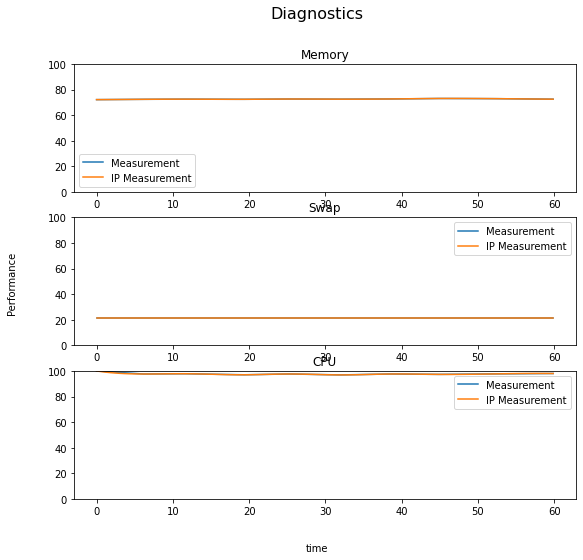

In [48]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate


assert upload.data, 'File missing, please upload in above cell'
data = json.loads(upload.data[0].decode('utf-8'))


meas_name = ['Memory', 'Swap', 'CPU']

bm_data = np.array([[],[],[],[]])
t0= data['resources_stats'][0]['time']

for meas in data['resources_stats']:
    dat = np.array([[meas['time']-t0, meas['memory']['used']/meas['memory']['total']*100, meas['swap']['used']/meas['swap']['total']*100, meas['cpu']['pcpu']]])
    bm_data = np.append(bm_data, dat.T, axis=1)


time_ip = np.linspace(bm_data[0][0], bm_data[0][-1], 100) 
bm_ip = np.array([time_ip])

fig, axes= plt.subplots(3, 1, figsize=(9, 8))
fig.text(0.5, 0.04, 'time', ha='center', va='center')
fig.text(0.03, 0.5, 'Performance', ha='center', va='center', rotation='vertical')

for i in range(len(bm_data)-1):
    tck = interpolate.splrep(bm_data[0], bm_data[i+1], s=0)
    ip = np.array([interpolate.splev(bm_ip[0], tck, der=0)])
    bm_ip = np.append(bm_ip, ip, axis=0)
    
    
    axes[i].plot(bm_data[0], bm_data[i+1], bm_ip[0], bm_ip[i+1])
    axes[i].legend(['Measurement', 'IP Measurement'])
    axes[i].set_title(meas_name[i])
    axes[i].set_ylim(0, 100)
    
    
fig.suptitle('Diagnostics', fontsize=16)
plt.show()